<a href="https://colab.research.google.com/github/yqr77452/DL/blob/main/CODING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem 1: Perform the following, in kaggle house price problem**
  
* **Set up**

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')

In [ ]:

# remove ID
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# standarizing
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# one-hot encoding
all_features = pd.get_dummies(all_features, dummy_na=True)
# convert it into the tensor representation for training
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

* **Training**

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [ ]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

* **K-Fold Validation**

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 1. **Vary the learning rate to 10, 1, 0.01, plot the training and validation errors respectively**

* **Learning rate = 10**

fold 1, train log rmse 0.149464, valid log rmse 0.148849
fold 2, train log rmse 0.145134, valid log rmse 0.162478
fold 3, train log rmse 0.143149, valid log rmse 0.148269
fold 4, train log rmse 0.147951, valid log rmse 0.147291
fold 5, train log rmse 0.143040, valid log rmse 0.174144
5-fold validation: avg train log rmse: 0.145748, avg valid log rmse: 0.156206


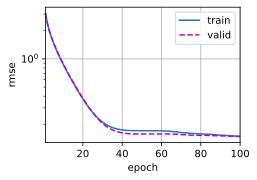

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64 
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Learning rate = 1**

fold 1, train log rmse 0.872038, valid log rmse 0.882597
fold 2, train log rmse 0.871426, valid log rmse 0.884458
fold 3, train log rmse 0.870893, valid log rmse 0.886060
fold 4, train log rmse 0.878491, valid log rmse 0.853503
fold 5, train log rmse 0.873182, valid log rmse 0.877269
5-fold validation: avg train log rmse: 0.873206, avg valid log rmse: 0.876777


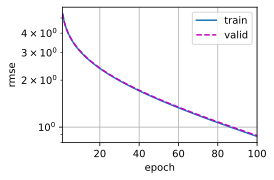

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Learning rate = 0.01**

fold 1, train log rmse 5.347209, valid log rmse 5.362094
fold 2, train log rmse 5.347662, valid log rmse 5.357826
fold 3, train log rmse 5.346372, valid log rmse 5.361495
fold 4, train log rmse 5.356172, valid log rmse 5.332070
fold 5, train log rmse 5.349296, valid log rmse 5.352632
5-fold validation: avg train log rmse: 5.349342, avg valid log rmse: 5.353223


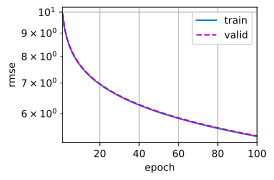

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Comparison**
  - Learning rate = 10 has the lowest train and validation set RMSE 
  - RMSE is high when learning rate is too high (>100) or too low (<0.1)

### **2. Change the optimizer to RMSprop and plot the errors. Note that you need to modify the lr to make the optimizer converge**

In [ ]:
def train_RMS(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.RMSprop(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
def k_fold_RMS(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train_RMS(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.132014, valid log rmse 0.144916
fold 2, train log rmse 0.128533, valid log rmse 0.147009
fold 3, train log rmse 0.127700, valid log rmse 0.144621
fold 4, train log rmse 0.133620, valid log rmse 0.132961
fold 5, train log rmse 0.125306, valid log rmse 0.163484
5-fold validation: avg train log rmse: 0.129434, avg valid log rmse: 0.146598


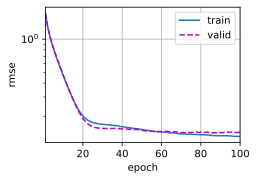

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64
train_l, valid_l = k_fold_RMS(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')
# After many lr trials in [0.01, 0.1, 1, 5, 10, 15, 20, 50, 100], 
# learning rate = 10 entails the lowest train & validation rmse

After many lr trials in [0.01, 0.1, 1, 5, 10, 15, 20, 50, 100], learning rate = 10 entails the lowest train & validation rmse.

### **3. Change the weight decay to 0.1, 1, 10, plot the errors**
* **Weight decay = 0.1**

fold 1, train log rmse 0.160523, valid log rmse 0.150900
fold 2, train log rmse 0.151760, valid log rmse 0.206926
fold 3, train log rmse 0.151526, valid log rmse 0.157461
fold 4, train log rmse 0.160055, valid log rmse 0.152218
fold 5, train log rmse 0.155329, valid log rmse 0.176441
5-fold validation: avg train log rmse: 0.155839, avg valid log rmse: 0.168789


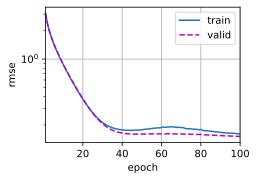

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Weight decay = 1**

fold 1, train log rmse 0.372155, valid log rmse 0.171060
fold 2, train log rmse 0.215683, valid log rmse 0.650523
fold 3, train log rmse 0.353099, valid log rmse 0.248841
fold 4, train log rmse 0.368716, valid log rmse 0.165017
fold 5, train log rmse 0.362864, valid log rmse 0.200289
5-fold validation: avg train log rmse: 0.334503, avg valid log rmse: 0.287146


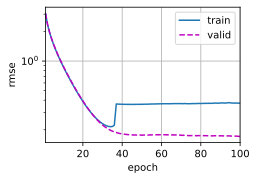

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Weight decay = 10**

fold 1, train log rmse 0.251556, valid log rmse 0.222883
fold 2, train log rmse 0.225413, valid log rmse 0.290093
fold 3, train log rmse 0.232313, valid log rmse 0.248404
fold 4, train log rmse 0.259594, valid log rmse 0.197355
fold 5, train log rmse 0.265712, valid log rmse 0.233779
5-fold validation: avg train log rmse: 0.246918, avg valid log rmse: 0.238503


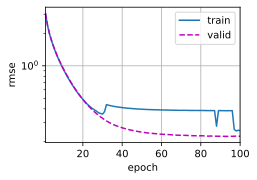

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 10, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Comparison**
  - Weight decay = 0 has the lowest train and validation RMSE in [0, 0.1, 1, 10]
  - As weight decay increase, the RMSE also increases in both set

### **4. Change the batch size to 32, 128, plot the errors**
* **Batch size = 32**

fold 1, train log rmse 0.133017, valid log rmse 0.144128
fold 2, train log rmse 0.130095, valid log rmse 0.146713
fold 3, train log rmse 0.128560, valid log rmse 0.143035
fold 4, train log rmse 0.133800, valid log rmse 0.137205
fold 5, train log rmse 0.126215, valid log rmse 0.166607
5-fold validation: avg train log rmse: 0.130337, avg valid log rmse: 0.147538


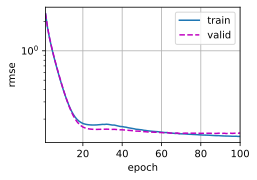

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Batch size = 128**

fold 1, train log rmse 0.169753, valid log rmse 0.157955
fold 2, train log rmse 0.161972, valid log rmse 0.194090
fold 3, train log rmse 0.162800, valid log rmse 0.167021
fold 4, train log rmse 0.167179, valid log rmse 0.154640
fold 5, train log rmse 0.161866, valid log rmse 0.182722
5-fold validation: avg train log rmse: 0.164714, avg valid log rmse: 0.171286


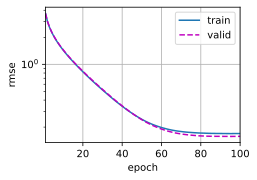

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Comparison**
  - batch size = 32 has the lowest train and validation RMSE in [32, 64, 128]
  - As batch size increases, the RMSE also increases in both set

### **5. Improve the model by inserting one hidden layer, which implements linear and ReLU activation. Choose the best learning rate, optimizer, weight decay, batch size, number of hidden nodes, plot the errors**

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.RMSprop(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):

        for x,y in train_iter: 
            l = loss(net(x), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [ ]:
def get_net_layer():
    net = nn.Sequential(nn.Flatten(),nn.Linear(in_features, 64), nn.ReLU(),
                        nn.Linear(64, 1)) # add layers
    return net

def k_fold_layer(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net_layer()
        net.apply(init_weights)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.128809, valid log rmse 0.135257
fold 2, train log rmse 0.125450, valid log rmse 0.145667
fold 3, train log rmse 0.123711, valid log rmse 0.139976
fold 4, train log rmse 0.129444, valid log rmse 0.125758
fold 5, train log rmse 0.116363, valid log rmse 0.157370
5-fold validation: avg train log rmse: 0.124755, avg valid log rmse: 0.140805


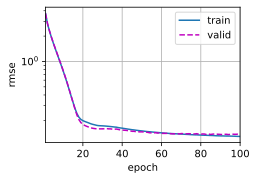

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 10, 32
train_l, valid_l = k_fold_layer(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

| No. of hidden nodes | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **16** | 0.081711 | 0.167537 |
| **32** | 0.072070 | 0.165757 |
| **64** | 0.069350 | 0.165870 |
| **128** | 0.076117 | 0.261530 |
| **256** | 0.088461  | 0.299707 |
| **512** | 0.098824  | 0.297399 |

* **Tuning process** :
  - No. of hidden nodes = 64

| learning rate | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **10** | 0.069350 | 0.165870 |
| **1** | 0.063841 | 0.156002 |
| **0.1** | 0.115907 | 0.159813 |
| **0.01** | 0.158144 | 0.166845 |

* **Tuning process** :
  - No. of hidden nodes = 64
  - learning rate = 0.01

| optimizer | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **Adam** | 0.158144 | 0.166845 |
| **RMSprop** | 0.145775 | 0.155699 |

* **Tuning process** :
  - No. of hidden nodes = 64
  - learning rate = 0.01
  - optimizer = RMSprop

| weight decay | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **0.1** | 0.141952 | 0.151779 |
| **0** | 0.145775 | 0.155699 |
| **1** | 0.140405 | 0.150886 |
| **10** | 0.138510 | 0.148883 |

* **Tuning process** :
  - No. of hidden nodes = 64
  - learning rate = 1
  - optimizer = RMSprop
  - weight decay = 10

| batch size | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **32** | 0.122962 | 0.138663 |
| **64** | 0.138510 | 0.148883 |
| **128** | 0.167792 | 0.171736 |


The final tuning result is: 
* **Tuning result** :
  - No. of hidden nodes = 64
  - learning rate = 1
  - optimizer = RMSprop
  - weight decay = 10
  - batch size = 32
  
 
* **log rmse**
  - avg train log rmse: 0.122962
  - avg valid log rmse: 0.138663
  
  
* Plot is above.
  
 

In [ ]:
def get_net_layer():
    net = nn.Sequential(nn.Flatten(),nn.Linear(in_features, 64), nn.ReLU(),
                        nn.Linear(64, 1)) # add layers
    return net

def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net_layer()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls],
             xlabel='epoch',
             ylabel='log rmse',
             xlim=[1, num_epochs],
             yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('/content/drive/My Drive/Colab Notebooks/submission.csv',index=False)

train log rmse 0.122507


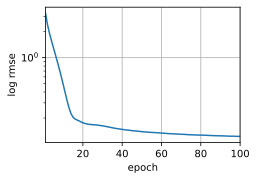

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 10, 32
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

### **6. Add dropout to the previously chosen model with one hidden layer for drop prob=0.5. Comment on your findings.**

In [ ]:
dropout = 0.5
def get_net_layer():
    net = nn.Sequential(nn.Flatten(),nn.Linear(in_features, 64), nn.ReLU(),
                        nn.Dropout(dropout),nn.Linear(64, 64),nn.ReLU(),
                        nn.Linear(64, 1))
    return net

def k_fold_layer(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net_layer()
        net.apply(init_weights)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.187493, valid log rmse 0.220605
fold 2, train log rmse 0.162056, valid log rmse 0.207045
fold 3, train log rmse 0.179386, valid log rmse 0.211668
fold 4, train log rmse 0.173433, valid log rmse 0.190877
fold 5, train log rmse 0.173292, valid log rmse 0.201246
5-fold validation: avg train log rmse: 0.175132, avg valid log rmse: 0.206288


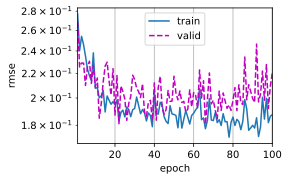

In [ ]:
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 10, 32
train_l, valid_l = k_fold_layer(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

* **Findings & Comments**
  - Both the training and test set cv log rmse has incresed by 40%-50%.
  - The validation set error becomes more random than the previous model without showing obvious trend,, and more close to white noise, which means it doesn't change towards a certain direction as epoch increases, unlike the previous model where randomness is not included in hidden layers.
  - The train set error, although still showing trend as epoch increases, has more uncertain randomness involved than the previous model.
  - This shows than adding a dropout layer with dropout probability=0.5 might be a bit too much, losing 40%-50% of its log rmse in both test and training. 
  - However, it does make the model less sensitive to the specific weights of layers, and in turn result a model which is less likely to overfit the training data.

### **7. What happens when you predict the logarithm of the price?**

In [ ]:
#take logarithm of the price
import math
train_data['logprice'] = train_data['SalePrice'].apply(
    lambda x: (math.log(x)))

train_labels = torch.tensor(
    train_data.logprice.values.reshape(-1, 1), dtype=torch.float32)

In [ ]:
def get_net_layer():
    net = nn.Sequential(nn.Flatten(),nn.Linear(in_features, 256), nn.ReLU(),
                        nn.Linear(256, 1)) # add layers
    return net

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):

        for x,y in train_iter: 
            l = loss(net(x), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

fold 1, train log rmse 0.008869, valid log rmse 0.011863
fold 2, train log rmse 0.017719, valid log rmse 0.017975
fold 3, train log rmse 0.008218, valid log rmse 0.014483
fold 4, train log rmse 0.008479, valid log rmse 0.010874
fold 5, train log rmse 0.011255, valid log rmse 0.020504
5-fold validation: avg train log rmse: 0.010908, avg valid log rmse: 0.015140


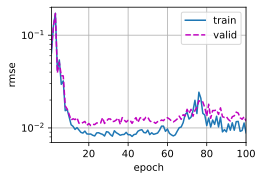

In [ ]:
# fit model & tuning
# training errors & validation errors
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 128
train_l, valid_l = k_fold_layer(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

| No. of hidden nodes | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **64** | 0.119764 | 0.120166 |
| **128** | 0.113515 |0.115399 |
| **256** | 0.108133  | 0.110878 |

* **Tuning process** :
  - No. of hidden nodes = 256
  
| learning rate | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **10** | 3.831321 | 3.870683 |
| **1** | 1.984834 | 1.999259 |
| **0.1** | 0.272366 | 0.281677 |
| **0.01** | 0.108133  | 0.110878 |

* **Tuning process** :
  - No. of hidden nodes = 256
  - learning rate = 0.01
  
| optimizer | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **Adam** | 0.101882 |  0.102383 |
| **RMSprop** | 0.108133  | 0.110878 |

* **Tuning process** :
  - No. of hidden nodes = 64
  - learning rate = 0.01
  - optimizer = Adam
  
| weight decay | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **0** | 0.012974 | 0.016272 |
| **0.1** | 0.021589 | 0.024578 |
| **1** | 0.046415 | 0.047461 |
| **10** | 0.101882 |  0.102383 |

* **Tuning process** :
  - No. of hidden nodes = 64
  - learning rate = 0.01
  - optimizer = Adam
  - weight decay = 0
  
| batch size | avg train log rmse | avg test log rmse | 
| :-----: | :----: | :----: |
| **32** | 0.012974 | 0.016272 |
| **64** | 0.020577 | 0.024441 |
| **128** | 0.010908 | 0.015140 |


The final tuning result is: 
* **Tuning result** :
  - No. of hidden nodes = 64
  - learning rate = 0.01
  - optimizer = Adam
  - weight decay = 0
  - batch size = 256
  
* **log rmse**
  - avg train log rmse:  0.010908
  - avg valid log rmse:  0.015140
  
* Plot is above.

* **Findings**
  - The average log rmse is in general smaller because we took log of the label
  - The best fitting parameters after trials are small learning rate, 0 weight decay, which are very different from the model without taking log

## **Problem 2: Perform the following to construct a more complex network and improve the accuracy**

### **1. Change the activation function to ReLU**

In [ ]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 2.303, train acc 0.098, test acc 0.100
6831.1 examples/sec on cpu


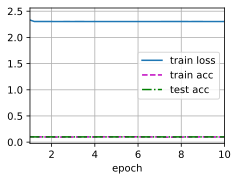

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

### **2. Change the average pooling to max pooling**

In [ ]:
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

loss 2.303, train acc 0.100, test acc 0.100
6643.7 examples/sec on cpu


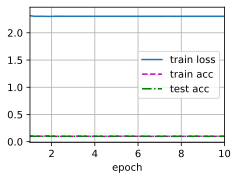

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

* Max pooling doesn't perform better than average pooling

### **3. Add nn.BatchNorm2d after the nn.Conv2d layers and nn.BatchNorm1d after of the nn.Linear layers**

loss 0.199, train acc 0.925, test acc 0.902
5415.3 examples/sec on cpu


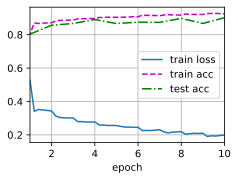

In [ ]:
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),nn.BatchNorm2d(16), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),nn.BatchNorm1d(120),nn.ReLU(), 
    nn.Linear(120, 84),nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

* It does achieve a lot better result than model without batch normalization, with test and train accuracy 

### 4. **Adjust the kernel size**

loss 0.209, train acc 0.921, test acc 0.874
5414.6 examples/sec on cpu


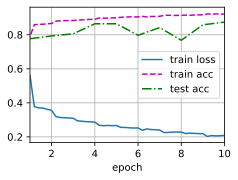

In [ ]:
# kernal size = 4
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=4, padding=2), nn.BatchNorm2d(6), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=4),nn.BatchNorm2d(16), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),nn.BatchNorm1d(120),nn.ReLU(), 
    nn.Linear(120, 84),nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

loss 0.220, train acc 0.917, test acc 0.880
4991.5 examples/sec on cpu


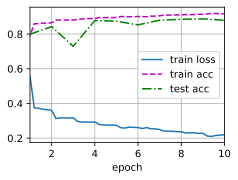

In [ ]:
# kernal size = 6
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=6, padding=3), nn.BatchNorm2d(6), nn.ReLU(), #also change the padding to 3 
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=6),nn.BatchNorm2d(16), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),nn.BatchNorm1d(120),nn.ReLU(), 
    nn.Linear(120, 84),nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

* When kernel size = 4, it doesn't have a higher test and train accuracy than when kernel size = 5
* When kernel size = 6, it doesn't have a higher test and train accuracy than when kernel size = 5

### 5. **Adjust the number of output channels**

loss 0.193, train acc 0.926, test acc 0.891
5290.8 examples/sec on cpu


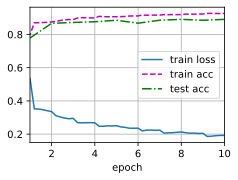

In [ ]:
# output channels = 12
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),nn.BatchNorm2d(12), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(12 * 5 * 5, 120),nn.BatchNorm1d(120),nn.ReLU(), 
    nn.Linear(120, 84),nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

loss 0.181, train acc 0.932, test acc 0.881
4316.5 examples/sec on cpu


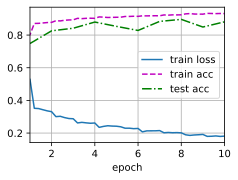

In [ ]:
# output channels = 20
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 20, kernel_size=5),nn.BatchNorm2d(20), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(20 * 5 * 5, 120),nn.BatchNorm1d(120),nn.ReLU(), 
    nn.Linear(120, 84),nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

* When output channels = 12,  it doesn't have a higher test and train accuracy than when output channels = 16
* When output channels = 20,  it doesn't have a higher test and train accuracy than when output channels = 16

## **Problem 3: Perform the following in  RNN: Transformers for Sentiment Analysis**

### 1. **Change the architecture to one layer unidirectional LSTM**

**Preparing data**

In [ ]:
import torch
import random
import numpy as np

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
import torch
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

aclImdb_v1.tar.gz:   0%|          | 81.9k/84.1M [00:00<01:46, 792kB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 56.5MB/s]


In [ ]:
LABEL.build_vocab(train_data)
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

**Build model**

In [ ]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')
import torch.nn as nn

class LSTMSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):    
        super().__init__()       
        self.bert = bert       
        embedding_dim = bert.config.to_dict()['hidden_size']        
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):      
        #text = [batch size, sent len]               
        with torch.no_grad():
            embedded = self.bert(text)[0]               
        #embedded = [batch size, sent len, emb dim)        
        _, (hidden,_) = self.rnn(embedded)        
        #hidden = [n layers * n directions, batch size, emb dim]        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])                
        #hidden = [batch size, hid dim]        
        output = self.out(hidden)        
        #output = [batch size, out dim]        
        return output

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1 #change to one-layer
BIDIRECTIONAL = False # not including bidirection means unidirection
DROPOUT = 0.25
model = LSTMSentiment(bert,
                      HIDDEN_DIM,
                      OUTPUT_DIM,
                      N_LAYERS,
                      BIDIRECTIONAL,
                      DROPOUT)

### 2. **How many trainable parameters are there in (1)**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 110,533,121 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,050,881 trainable parameters




*   *After freezing some paramers, the model has 1,050,881 trainable parameters*



### 3. **What is the best number of epochs for (1)?**

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):  
    epoch_loss = 0
    epoch_acc = 0    
    model.train()    
    for batch in iterator:        
        optimizer.zero_grad()     
        predictions = model(batch.text).squeeze(1)      
        loss = criterion(predictions, batch.label)       
        acc = binary_accuracy(predictions, batch.label)       
        loss.backward()      
        optimizer.step()       
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):    
    epoch_loss = 0
    epoch_acc = 0  
    model.eval()  
    with torch.no_grad():   
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)         
            loss = criterion(predictions, batch.label)          
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()       
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 33s
	Train Loss: 0.678 | Train Acc: 53.88%
	 Val. Loss: 0.586 |  Val. Acc: 72.40%
Epoch: 02 | Epoch Time: 6m 33s
	Train Loss: 0.660 | Train Acc: 56.07%
	 Val. Loss: 0.509 |  Val. Acc: 77.03%
Epoch: 03 | Epoch Time: 6m 33s
	Train Loss: 0.652 | Train Acc: 58.31%
	 Val. Loss: 0.501 |  Val. Acc: 73.93%
Epoch: 04 | Epoch Time: 6m 33s
	Train Loss: 0.656 | Train Acc: 58.52%
	 Val. Loss: 0.571 |  Val. Acc: 68.87%
Epoch: 05 | Epoch Time: 6m 33s
	Train Loss: 0.591 | Train Acc: 67.78%
	 Val. Loss: 0.421 |  Val. Acc: 83.50%




*  *The best number of epoches is 5 in [1:5], it has the highest train and validation set accuracy*



### 4. **What is the final test accuracy for the new architecture in (1)? How does it compare with two layer bidirectional GRU?**

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.401 | Test Acc: 84.17%




*   *The final test accuracy is 84.17%*
*   *The one layer unidirectional LSTM model has lower test accuracy （84.17%） compared with two layer bidirectional GRU （91.92%）. Thus, we can conclude that by including multiple layers and bidirectional method, the model shows remarkable performance improvement.*
